In [1]:
from BovadaProcessor import Frame
from deuces import Card
from deuces import Evaluator
import time
import os
from collections import Counter
from IPython.display import clear_output
import numpy as np
from PokerMath import PokerMath

In [9]:
pmath?

Object `pmath` not found.


In [31]:
play = True
ai = AI()
pmath = PokerMath()
frame = Frame(blinds = .05)


while play:    
    frame.update()
    
    while frame.identify_card('hole1') is None or frame.identify_card('hole2') is None:
        #print 'no cards found'
        time.sleep(1)
        frame.update()
    
        
    c1 = frame.identify_card('hole1')
    c2 = frame.identify_card('hole2') 
    
    Card.print_pretty_cards([Card.new(c1), Card.new(c2)])
    
    ## check to see if we should fold the cards immediately
    if frame.user_position() != 'BB' and not ai.in_play_list(c1, c2):          
        print 'FOLDING'
        frame.fold()
             
    #otherwise, wait and watch the other players
    else:    
        #Don't stay in the hand if we have a shitty hand on BB and somebody raised
        if frame.user_position() is 'BB' and frame.bets().max() > frame.blinds and not ai.in_play_list(c1, c2):
            print "Folding on BB. Somebody bet and we have shitty cards"
            frame.fold()
            
        
        elif frame.is_user_turn():
            print 'entering hand loop'
            hand_loop(ai, frame, c1, c2)
    
    time.sleep(1)
        
    

  [ 8 ❤ ] , [ 8 ♣ ]  
  [ 8 ❤ ] , [ 8 ♣ ]  
  [ 8 ❤ ] , [ 8 ♣ ]  
  [ 8 ❤ ] , [ 8 ♣ ]  
  [ 8 ❤ ] , [ 8 ♣ ]  
entering hand loop
it's our turn!
Pre-flop. Calculating Bet
first bet
position: BTN
pot 0.22
1 raisers
0 callers
UTG ... raiser position
call
it's our turn!
Pre-flop. Calculating Bet
first bet
position: BTN
pot 0.22
1 raisers
0 callers
UTG ... raiser position
call
it's our turn!
flop
['2c', '7h', '4h']
num players in: 3
monte carlo result: 0.86
it's our turn!
flop
['2c', '7h', '4h']
num players in: 3
monte carlo result: 0.861
it's our turn!
turn
it's our turn!
turn
it's our turn!
river
it's our turn!
river
it's our turn!
river
  [ 7 ❤ ] , [ 7 ♣ ]  
  [ 7 ❤ ] , [ 7 ♣ ]  
  [ 7 ❤ ] , [ 7 ♣ ]  
  [ 7 ❤ ] , [ 7 ♣ ]  
  [ 7 ❤ ] , [ 7 ♣ ]  
  [ 7 ❤ ] , [ 7 ♣ ]  
entering hand loop
it's our turn!
Pre-flop. Calculating Bet
first bet
position: BB
pot 0.12
1  limpers
call
it's our turn!
flop
['8c', '4h', '8h']
num players in: 2
monte carlo result: 0.88
it's our turn!
flop
['8c', '4h', '8

KeyboardInterrupt: 

In [30]:
def hand_loop(ai, frame, c1, c2):
    play = True
    position = frame.user_position()
    
    
    while play and frame.identify_card('hole1') == c1: 
        frame.update()
    
        if frame.is_user_turn():
            #first let's check which round of betting we're on
            print "it's our turn!"
            
            if frame.identify_card('board5') is not None:
                print 'river'
            elif frame.identify_card('board4') is not None:
                print 'turn'
            elif frame.identify_card('board1') is not None:
                print 'flop'
                flop = [frame.identify_card('board1'), frame.identify_card('board2'), frame.identify_card('board3')]
                print flop
                print 'num players in:', np.count_nonzero(frame.in_hand())
                print "monte carlo result:" , pmath.hand_strength([c1,c2], flop,\
                        num_players = np.count_nonzero(frame.in_hand()) - 1, current = True)
            
            else: 
            ##############################################
            ############### PREFLOP ######################
           
                #We must be preflop
                print 'Pre-flop. Calculating Bet'
                
        

                #Is this our first bet?
                bet = frame.read_value('bet0') #read our bet (if any)
                if bet <= frame.blinds or bet is None:
                    print 'first bet'
                    bet = ai.first_preflop_bet(frame, c1, c2) 
                    print bet
                    if bet == 'fold':
                        frame.fold()    
                        return
                    elif bet == 'call':
                        frame.call()              
                    else:
                        frame.bet(bet)


                #We already bet once. 
                else:
                    print "there's been a reraise"
                    bet = ai.handle_preflop_reraise(frame, c1, c2)
                    if bet == 'fold':
                        frame.fold()    
                        return
                    elif bet == 'call':
                        frame.call()              
                    else:
                        frame.bet(bet)

            ################################################
            ################################################
        time.sleep(3)
                

In [6]:
class AI():
    def __init__(self):
        self.pairs_1 = ['AA', 'KK', 'QQ']
        self.pairs_2 = ['JJ', 'TT', '99'] 
        self.pairs_3 = ['88', '77']
        self.pairs_4 = ['66', '55', '44', '33', '22']
        self.pairs = self.pairs_1 + self.pairs_2 + self.pairs_3 + self.pairs_4

        self.suited_connectors_1 = ['KQs', 'JQs', 'JTs']
        self.suited_connectors_2 = ['9Ts', '89s', '78s', '67s']
        self.suited_connectors_3 = ['56s', '45s', '34s', '23s']
        self.suited_connectors = self.suited_connectors_1 + self.suited_connectors_2 + self.suited_connectors_3

        self.suited_connectors_one_gap_1 = ['JKs', 'QTs', '9Js']
        self.suited_connectors_one_gap_2 = ['8Ts', '79s', '68s']
        self.suited_connectors_one_gap_3 = ['57s', '46s', '35s', '24s']
        self.suited_connectors_one_gap = self.suited_connectors_one_gap_1 + self.suited_connectors_one_gap_2 + self.suited_connectors_one_gap_3

        self.suited_connectors_two_gap_1 = ['KTs', '9Qs', '8Js']
        self.suited_connectors_two_gap_2 = ['7Ts', '69s', '58s']
        self.suited_connectors_two_gap_3 = ['47s', '36s', '25s']
        self.suited_connectors_two_gap = self.suited_connectors_two_gap_1 + self.suited_connectors_two_gap_2 + self.suited_connectors_two_gap_3
        
        self.all_suited_connectors =  self.suited_connectors_one_gap + self.suited_connectors_two_gap + self.suited_connectors 
        
        
        self.suited_aces_1 = ['AJs', 'ATs']
        self.suited_aces_2 = ['6As', '7As', '8As', '9As']
        self.suited_aces_3 = ['2As', '3As', '4As', '5As']
        self.suited_aces = self.suited_aces_1 + self.suited_aces_2 + self.suited_aces_3 

        self.big_aces = ['AKs', 'AK', 'AQ', 'AQs']
        
        '''If our hand is not in this list, fold IMMEDIATELY (unless big blind)'''
        self.play_list = self.pairs + self.suited_connectors + self.suited_connectors_one_gap + \
                         self.suited_connectors_two_gap + self.suited_aces  + self.big_aces
                   
    def encode_hand(self, c1, c2):
        if c1[1] == c2[1]:
            encoded_hand = c1[0]+c2[0]+'s'
        else:
            encoded_hand = c1[0]+c2[0] 
        return ''.join(sorted(encoded_hand))
    
    def in_play_list(self, c1, c2):
        '''Returns false if we should fold hand immediately'''
        hand = self.encode_hand(c1, c2)
        return hand in self.play_list
    def num_raisers(self, bets, max_bet = 0):
        raisers = 0
        for bet in bets:
            if bet > max_bet:
                raisers+= 1
                max_bet = bet
        return raisers
    def num_limpers(self, bets, position, blinds):
        num_limpers = len(bets[bets == blinds]) - 1  
        if position is 'BB':
            num_limpers += 1
        return num_limpers 
    def is_unopened(self, position, bets, blinds):
        return position != 'BB' and len(bets[bets >= blinds]) == 1
    def is_limpers(self, bets, blinds):
        return bets.max() <= blinds
    def raiser_position(self, bets,position):   
        positions = ['BTN', 'SB', 'BB','UTG', 'MP', 'CO']
        user_index = positions.index(position)
        return positions[(user_index + np.argmax(bets) + 1)%6]
    def bet_by_position(self, bets, our_position, opp_position):
        positions = ['BTN', 'SB', 'BB','UTG', 'MP', 'CO']
        user_index = positions.index(our_position)
        bet_index = positions.index(opp_position)
        if user_index <= bet_index:
            loc = bet_index-user_index
        else:
            loc = ((6 - user_index) + bet_index)%6
        return bets[loc - 1]
    
           
    
    
    def first_preflop_bet(self, frame, c1, c2):
        hand = self.encode_hand(c1, c2)
        bets = frame.bets()
        pot = float(frame.read_value('pot'))
        blinds = frame.blinds
        position = frame.user_position()
        
        print 'position:' , position
        print 'pot', pot
        
        if self.is_unopened(position, bets, blinds):
            print "Unopened"
        elif self.is_limpers(bets, blinds):
            print self.num_limpers(bets, position, blinds), " limpers"
        else:
            print self.num_raisers(bets, max_bet = blinds) , 'raisers'
            print max(Counter(bets).most_common())[1] - 1, 'callers'
            print self.raiser_position(bets, position) , '... raiser position'
            
          
        
        if position is 'UTG':
            if hand in self.pairs_1 + self.pairs_2 + self.pairs_3 + self.big_aces:
                    return 3*blinds
            elif hand in  self.pairs_4 + self.suited_connectors_1 + self.suited_connectors_2 \
                          + self.suited_connectors_one_gap_2 + self.suited_aces_3 + self.suited_aces_1:
                    return 2*blinds
        if position is 'MP':
            if self.is_unopened(position, bets, blinds):
                if hand in self.pairs_1 + self.pairs_2 + self.pairs_3 + self.suited_connectors_1 \
                   + self.suited_connectors_2 + self.suited_aces_1 + self.big_aces:
                    return 3*blinds  
                elif hand in self.pairs_4 + self.suited_connectors_2 + self.suited_connectors_one_gap + self.suited_aces_3:
                    return 2*blinds
            elif self.is_limpers(bets, blinds):
                if hand in self.pairs_1:
                    return 6*blinds
                elif hand in ['AKs', 'JJ']:
                    return 5*blinds
                elif hand in ['TT', '99', 'AK', 'AQs']:
                    return 4*blinds
                elif hand in self.pairs_3 + self.suited_aces_1:
                    return 3*blinds
                elif self.pairs_4 + self.suited_connectors_1 + self.suited_connectors_2 + self.suited_connectors_one_gap_1\
                   + self.suited_connectors_one_gap_2 + self.suited_aces_3:
                    return 'call'
            else: #UTG must have raised
                villan_bet = bets.max()
                if villan_bet >= 5*blinds:
                    if hand in self.pairs_1:
                        return 2*pot
                elif villan_bet >= 4*blinds:
                    if hand in self.pairs_1:
                        return 2*pot
                    if hand in self.pairs_2 + self.big_aces:
                        return 'call'
                elif villan_bet >= 3*blinds:
                    if hand in self.pairs_1 + ['AKs', 'AK']:
                        return 2*pot
                    if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_1\
                               + self.suited_connectors_2  + self.suited_connectors_one_gap_1 +\
                               + self.suited_connectors_one_gap_2 + self.big_aces:
                        return 'call'
                else:
                    if hand in self.pairs_1 + self.pairs_2 + self.big_aces:
                        return 2*pot
                    if hand in self.pairs_3 + self.pairs_4 + self.suited_connectors_1  + self.suited_connectors_2\
                               + self.suited_connectors_one_gap_1 + self.suited_connectors_one_gap_2\
                               + self.suited_aces_1 + self.suited_aces_3:
                        return 'call'
        if position is 'CO':
            if self.is_unopened(position, bets, blinds):
                if self.pairs + self.suited_connectors_1 + self.suited_connectors_2 + self.suited_connectors_one_gap_1\
                    + self.suited_connectors_one_gap_2 + self.suited_aces_1 + self.suited_connectors_3 + self.big_aces:
                    return 3*blinds
                
            elif self.is_limpers(bets, blinds):
                num_limpers = self.num_limpers(bets, position, blinds)
                if num_limpers is 1:         
                    if hand in self.pairs_1:
                        return 6*blinds
                    if hand in ['AKs', 'JJ']:
                        return 5*blinds
                    if hand in ['TT', '99', 'AK', 'AQs']:
                        return 4*blinds
                    if hand in self.pairs_3 + self.suited_aces_1:
                        return 3*blinds
                    if self.pairs_4 + self.suited_connectors_1 + self.suited_connectors_2 + self.suited_connectors_one_gap_1\
                       + self.suited_connectors_one_gap_2 + self.suited_aces_3:
                        return 'call'
                if num_limpers is 2:
                    if hand in self.pairs_1:
                        return 8*blinds
                    if hand in self.pairs_2 + self.big_aces:
                        return 6*blinds
                    if hand in  self.pairs_3 + self.pairs_4 + self.suited_connectors + self.suited_connectors_one_gap\
                                + self.suited_connectors_two_gap + self.suited_aces:
                        return 'call'
            else: #Must be raiser
                num_raisers = self.num_raisers(bets, max_bet = blinds)
                villan_bet = bets.max()
                if num_raisers is 1:
                    num_callers = max(Counter(bets).most_common())[1] - 1       
                    if num_callers is 0:
                        if villan_bet >= 5*blinds:
                            if hand in self.pairs_1:
                                return 2*pot
                        elif villan_bet >= 4*blinds:
                            if hand in self.pairs_1:
                                return 2*pot
                            if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_2\
                                        + self.suited_connectors_one_gap_2 + ['AKs', 'AK']:
                                return 'call'
                        elif villan_bet >= 3*blinds:
                            if hand in self.pairs_1 + ['AKs', 'AK']:
                                return 2*pot
                            if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_1\
                                       + self.suited_connectors_2  + self.suited_connectors_one_gap_1 +\
                                       + self.suited_connectors_one_gap_2 + self.big_aces:
                                return 'call'
                        else:
                            if hand in self.pairs_1 + self.pairs_2 + self.big_aces:
                                return 2*pot
                            if hand in self.pairs_3 + self.pairs_4 + self.suited_connectors_1 + self.suited_connectors_2\
                                       + self.suited_connectors_one_gap_1 + self.suited_connectors_one_gap_2\
                                       + self.suited_aces_1 + self.suited_aces_3:
                                return 'call'                  
                    elif num_callers is 1:
                        if villan_bet >= 7*blinds:
                            if hand in self.pairs_1:
                                return 3*pot
                        elif villan_bet >= 5*blinds:
                            if hand in self.pairs_1:
                                return 2*pot
                            if hand is 'AKs':
                                return 'call'         
                        elif villan_bet >= 4*blinds:
                            if hand in self.pairs_1:
                                return 2*pot
                            if hand in self.pairs_2 + self.big_aces:
                                return 'call'
                        elif villan_bet >= 3*blinds:
                            if hand in self.pairs_1:
                                return 2*pot
                            if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_2\
                                       + self.suited_connectors_one_gap_2 + self.big_aces:
                                return 'call'
                        else:
                            if hand in self.pairs_1 + ['AKs', 'AK']:
                                return 2*pot
                            if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors\
                                       + self.suited_connectors_one_gap + self.suited_connectors_two_gap_2\
                                       + self.suited_aces + ['AQs', 'AQ']:
                                return 'call'
                if num_raisers >= 2:
                    if villan_bet > 12*blinds:
                        if hand in self.pairs_1:
                            return 2.5*pot
                    elif villan_bet > 9*blinds:
                        if hand in self.pairs_1:
                            return 2.5*pot
                        if hand is 'AKs':
                            return 'call'
                        
                    elif villan_bet >= 6*blinds:
                        if hand in self.pairs_1:
                            return 2.5*pot
                        if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                    + ['AKs', 'AK']:
                            return 'call'
                    elif villan_bet >= 3*blinds:
                        if hand in self.pairs_1:
                            return 2.5*pot
                        if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_2\
                                    + self.suited_connectors_one_gap_2 + ['AKs', 'AK']:
                            return 'call'
                                
        if position is 'BTN':
            if self.is_unopened(position, bets, blinds):
                if self.pairs + self.suited_connectors + self.suited_connectors_one_gap + self.suited_connectors_two_gap\
                    + self.suited_aces + self.big_aces:
                    return 3*blinds
                
            elif self.is_limpers(bets, blinds):
                num_limpers = self.num_limpers(bets, position, blinds)
                if num_limpers is 1:         
                    if hand in self.pairs_1:
                        return 5*blinds
                    if hand in self.pairs_2 + self.big_aces:
                        return 4*blinds
                    if hand in self.pairs_3 + self.pairs_4 + self.suited_connectors_1 + self.suited_connectors_2\
                                + self.suited_connectors_one_gap_1 + self.suited_connectors_one_gap_2 + self.suited_aces_1:
                        return 3*blinds
                    if hand in self.pairs_3 + self.suited_aces_1:
                        return 3*blinds
                    if hand in self.suited_connectors_3 + self.suited_connectors_one_gap_3 + self.suited_connectors_two_gap\
                               + self.suited_aces_2 + self.suited_aces_3:
                        return 'call'
                if num_limpers is 2:
                    if hand in self.pairs_1:
                        return 7*blinds
                    if hand in self.pairs_2 + self.big_aces:
                        return 5*blinds
                    if hand in  self.pairs_3 + self.pairs_4 + self.suited_connectors + self.suited_connectors_one_gap\
                                + self.suited_connectors_two_gap + self.suited_aces:
                        return 'call'
                if num_limpers is 3:
                    if hand in self.pairs_1:
                        return 10*blinds
                    if hand in self.pairs_2 + self.big_aces:
                        return 6*blinds
                    if hand in  self.pairs_3 + self.pairs_4 + self.suited_connectors + self.suited_connectors_one_gap\
                                + self.suited_connectors_two_gap + self.suited_aces:
                        return 'call'
            else: #Must be raiser
                num_raisers = self.num_raisers(bets, max_bet = blinds)
                villan_bet = bets.max()
                
                if num_raisers is 1:
                    num_callers = max(Counter(bets).most_common())[1] - 1
                    
                    if self.bet_by_position(bets, position, 'UTG') > blinds or self.bet_by_position(bets, position, 'MP') > blinds:    
                        if num_callers is 0:
                            if villan_bet > 5*blinds:
                                if hand in self.pairs_1:
                                    return 2*pot
                            elif villan_bet >= 4*blinds:
                                if hand in self.pairs_1:
                                    return 2*pot
                                if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                            +['AK', 'AKs']:
                                    return 'call'

                            elif villan_bet >= 3*blinds:
                                if hand in self.pairs_1 + ['AKs']:
                                    return 2*pot
                                if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors\
                                            + self.suited_connectors_one_gap + self.suited_connectors_two_gap_1\
                                            +  self.suited_connectors_two_gap_2 + self.big_aces:
                                    return 'call'
                            else:
                                if hand in self.pairs_1 + self.pairs_2 + self.big_aces:
                                    return 2*pot
                                else:
                                    return 'call'
                        if num_callers > 0:
                            if villan_bet > 5*blinds:
                                if hand in self.pairs_1:
                                    return 2*pot
                            elif villan_bet >= 4*blinds:
                                if hand in self.pairs_1:
                                    return 2.5*pot
                                if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_1\
                                            + self.suited_connectors_2 + self.suited_connectors_3\
                                            + self.suited_connectors_one_gap + self.suited_connectors_two_gap\
                                            + self.suited_aces_3 + ['AK', 'AKs', 'AQs']:
                                    return 'call'

                            elif villan_bet >= 3*blinds:
                                if hand in self.pairs_1 + ['AKs', 'JJ']:
                                    return 2.5*pot
                                else:
                                    return 'call'
                            else:
                                if hand in self.pairs_1 + ['AKs', 'JJ']:
                                    return 2.5*pot
                                if hand in ['AK', 'AQs']:
                                    return 1.75*pot
                                else:
                                    return 'call'
                                        
                    else: #cutoff raiser
                        if villan_bet >= 5*blinds:
                            if hand in self.pairs_1:
                                return 2*pot
                        elif villan_bet >= 4*blinds:
                            if hand in self.pairs_1:
                                return 2*pot
                            if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                        + ['AK', 'AKs']:
                                return 'call'
                        elif villan_bet >= 3*blinds:
                            if hand in self.pairs_1 + self.pairs_2 + ['AKs', 'AK']:
                                return 2*pot
                            if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors\
                                        + self.suited_connectors_one_gap + self.suited_connectors_two_gap_1\
                                        + self.suited_connectors_two_gap_2 + self.big_aces:
                                return 'call'
                        else:
                            if hand in self.pairs_1 + self.pairs_2 + self.pairs_3 + self.big_aces\
                                        + self.suited_connectors_1 +  self.suited_connectors_2 + self.suited_connectors_one_gap_2:
                                return 2*pot
                            else:
                                return 'call'
                
                if num_raisers >= 2:
                    if villan_bet > 12*blinds:
                        if hand in self.pairs_1:
                            return 2.5*pot
                    elif villan_bet > 9*blinds:
                        if hand in self.pairs_1:
                            return 2.5*pot
                        if hand is 'AKs':
                            return 'call'
                        
                    elif villan_bet >= 6*blinds:
                        if hand in self.pairs_1:
                            return 2.5*pot
                        if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                    + ['AKs', 'AK']:
                            return 'call'
                    elif villan_bet >= 3*blinds:
                        if hand in self.pairs_1:
                            return 2.5*pot
                        if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_2\
                                    + self.suited_connectors_one_gap_2 + ['AKs', 'AK']:
                            return 'call'
                               
        if position is 'SB':
            if self.is_unopened(position, bets, blinds):
                if hand in self.pairs + self.suited_connectors_1 + self.suited_connectors_2 \
                            + self.suited_connectors_one_gap_1 +  self.suited_connectors_one_gap_2\
                            + self.suited_connectors_two_gap_1  + self.suited_aces + self.big_aces:
                    return 3*blinds
                
            elif self.is_limpers(bets, blinds):
                num_limpers = self.num_limpers(bets, position, blinds)
                raise_amount = [0, 7, 10, 15, 20]
                if hand in self.pairs_1:
                    return raise_amount[num_limpers]*blinds
                if hand in self.pairs_2 + self.pairs_3 + self.pairs_4\
                            + self.suited_connectors + self.suited_connectors_one_gap + self.suited_connectors_two_gap\
                            + self.big_aces + self.suited_aces:
                    return 'call'
            else: #Must be raiser
                num_raisers = self.num_raisers(bets, max_bet = blinds)
                villan_bet = bets.max()
                
                if num_raisers is 1:
                    num_callers = max(Counter(bets).most_common())[1] - 1
                    if self.bet_by_position(bets, position, 'UTG') > blinds or self.bet_by_position(bets, position, 'MP') > blinds or self.bet_by_position(bets, position, 'CO'):
                        if num_callers is 0:
                            if villan_bet >= 5*blinds:
                                if hand in self.pairs_1:
                                    return 3.5*pot
                            elif villan_bet >= 4*blinds:
                                if hand in self.pairs_1:
                                    return 3.5*pot
                                if hand in self.pairs_2 + ['AKs', 'AK']:
                                    return 'call'
                            else:
                                if hand in self.pairs_1 + ['AKs', 'AK']:
                                    return 3.5*pot
                                if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                            + self.big_aces:
                                    return 'call'
                        if num_callers >= 1:
                            if villan_bet >= 7*blinds:
                                if hand in self.pairs_1:
                                    return 3.5*pot
                            elif villan_bet >= 5*blinds:
                                if hand in self.pairs_1:
                                    return 3.5*pot
                                if hand in self.pairs_2 + ['AKs']:
                                    return 'call'
                            elif villan_bet >= 4*blinds:
                                if hand in self.pairs_1 + ['JJ', 'AKs', 'AK']:
                                    return 3.5*pot
                                if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2 +['AKs', 'AQs']:
                                    return 'call'
                            elif villan_bet >= 3*blinds:
                                if hand in self.pairs_1 + ['JJ','AKs', 'AK']:
                                    return 3.5*pot
                                if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_2\
                                            + self.suited_connectors_one_gap_2 + self.suited_aces:
                                    return 'call'
                            else:
                                if hand in self.pairs_1 + ['JJ', 'AKs', 'AK']:
                                    return 3.5*pot
                                if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_2\
                                            + self.suited_connectors_one_gap_2 + self.suited_aces:
                                    return 'call'
                                             
                    else: #button raised
                        if villan_bet >= 7*blinds:
                            if hand in self.pairs_1:
                                return 3.5*pot
                        elif villan_bet >= 5*blinds:
                            if hand in self.pairs_1:
                                return 3.5*pot
                            if hand is 'AKs':
                                return 'call'
                        elif villan_bet >= 4*blinds:
                            if hand in self.pairs_1 + ['JJ', 'AKs']:
                                return 3.5*pot
                            if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2 +['AKs', 'AQs']:
                                return 'call'
                        elif villan_bet >= 3*blinds:
                            if hand in self.pairs_1 + self.pairs_2 + ['AKs', 'AK']:
                                return 3.5*pot
                            if hand in self.suited_connectors_2  + self.suited_connectors_one_gap_2 + ['AQs','AQ']:
                                return 'call'
                        else:
                            if hand in self.pairs_1 + self.big_aces + self.pairs_2:
                                return 3.5*pot
                            if hand in self.pairs_3 + self.suited_connectors_1 + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                            + self.suited_connectors_one_gap_1 + self.suited_aces_1:
                                return 'call'
                            
                if num_raisers >= 2: 
                    if villan_bet >= 12*blinds:
                        if hand in self.pairs_1:
                            return 3.5*pot
                    elif villan_bet > 9*blinds:
                        if hand in self.pairs_1:
                            return 3.5*pot
                        if hand in ['AKs','JJ']:
                            return 'call'
                        
                    elif villan_bet >= 6*blinds:
                        if hand in self.pairs_1:
                            return 3.5*pot
                        if hand in self.pairs_2 + ['AKs']:
                            return 'call'
                    elif villan_bet >= 3*blinds:
                        if hand in self.pairs_1 + ['JJ', 'AKs', 'AK']:
                            return 3.5*pot
                        if hand in self.pairs_2 +self.pairs_3 + self.suited_connectors_2\
                                    + self.suited_connectors_one_gap_2 + ['AQs']:
                            return 'call'
        
        if position is 'BB':
            if self.is_limpers(bets, blinds):
                num_limpers = self.num_limpers(bets, position, blinds)
                raise_amount = [0, 7, 10, 15, 20, 25]
                if hand in self.pairs_1:
                    return raise_amount[num_limpers]*blinds
                else:
                    return 'call'
                
            else: #Must be raiser
                num_raisers = self.num_raisers(bets, max_bet = blinds)
                villan_bet = bets.max()
                
                if num_raisers is 1:
                    num_callers = max(Counter(bets).most_common())[1] - 1
                    if self.bet_by_position(bets, position, 'UTG') > blinds or self.bet_by_position(bets, position, 'MP') > blinds or self.bet_by_position(bets, position, 'CO'):
                        if num_callers is 0:
                            if villan_bet >= 5*blinds:
                                if hand in self.pairs_1:
                                    return 3.5*pot
                            elif villan_bet >= 4*blinds:
                                if hand in self.pairs_1:
                                    return 3.5*pot
                                if hand in self.pairs_2 + ['AKs', 'AK']:
                                    return 'call'
                            else:
                                if hand in self.pairs_1 + ['AKs']:
                                    return 3.5*pot
                                if hand is 'AK':
                                    return 2*pot
                                if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                            + self.big_aces:
                                    return 'call'
                        if num_callers >= 1:
                            if villan_bet >= 7*blinds:
                                if hand in self.pairs_1:
                                    return 3.5*pot
                            elif villan_bet >= 5*blinds:
                                if hand in self.pairs_1:
                                    return 3.5*pot
                                if hand in self.pairs_2 + ['AKs']:
                                    return 'call'
                            elif villan_bet >= 4*blinds:
                                if hand in self.pairs_1 + ['JJ', 'AKs', 'AK']:
                                    return 3.5*pot
                                if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2 +['AKs', 'AQs']:
                                    return 'call'
                            elif villan_bet >= 3*blinds:
                                if hand in self.pairs_1 + ['JJ','AKs', 'AK']:
                                    return 3.5*pot
                                if hand in self.pairs_2 +  self.pairs_3 + self.pairs_4 + self.suited_connectors_2\
                                            + self.suited_connectors_one_gap_2 + self.suited_aces:
                                    return 'call'
                            else:
                                if hand in self.pairs_1 + ['JJ', 'AKs', 'AK']:
                                    return 3.5*pot
                                if hand in self.pairs_2 + self.pairs_3 + self.pairs_4 + self.suited_connectors_2\
                                            + self.suited_connectors_one_gap_2 + self.suited_aces:
                                    return 'call'
                            
                                
                    elif self.bet_by_position(bets, position, 'BTN') > blinds: #button raised
                        if villan_bet >= 7*blinds:
                            if hand in self.pairs_1:
                                return 3.5*pot
                        elif villan_bet >= 5*blinds:
                            if hand in self.pairs_1:
                                return 3.5*pot
                            if hand is 'AKs':
                                return 'call'
                        elif villan_bet >= 4*blinds:
                            if hand in self.pairs_1 + ['JJ', 'AKs']:
                                return 3.5*pot
                            if hand in self.pairs_2 + self.suited_connectors_2 + self.suited_connectors_one_gap_2 +['AKs', 'AQs']:
                                return 'call'
                        elif villan_bet >= 3*blinds:
                            if hand in self.pairs_1 + self.pairs_2 + ['AKs', 'AK']:
                                return 3.5*pot
                            if hand in self.suited_connectors_2  + self.suited_connectors_one_gap_2 + ['AQs','AQ']:
                                return 'call'
                        else:
                            if hand in self.pairs_1 + self.big_aces + self.pairs_2:
                                return 3.5*pot
                            if hand in self.pairs_3 + self.suited_connectors_1 + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                            + self.suited_connectors_one_gap_1 + self.suited_aces_1:
                                return 'call'
                    else: #SB raised
                        if villan_bet >= 10*blinds:
                            if hand in self.pairs_1:
                                return 2.5*pot
                        elif villan_bet >= 5*blinds:
                            if hand in self.pairs_1:
                                return 2.5*pot
                            if hand in ['AKs', 'AK', 'JJ', 'TT']:
                                return 'call'
                        elif villan_bet >= 4*blinds:
                            if hand in self.pairs_1:
                                return 2.5*pot
                            if hand in self.pairs_2 + self.pairs_3 + self.suited_connectors_1\
                                        + self.suited_connectors_2 + self.suited_connectors_one_gap_2\
                                        + self.suited_connectors_one_gap_1 + self.suited_aces_1 + self.big_aces:
                                return 'call'
                        else:
                            if hand in self.pairs_1 + self.big_aces + self.pairs_2:
                                return 2.5*pot
                            if hand in self.play_list:
                                return 'call'
                                       
                if num_raisers >= 2: 
                    if villan_bet >= 12*blinds:
                        if hand in self.pairs_1:
                            return 3.5*pot
                    elif villan_bet > 9*blinds:
                        if hand in self.pairs_1:
                            return 3.5*pot
                        if hand in ['AKs','JJ']:
                            return 'call'
                        
                    elif villan_bet >= 6*blinds:
                        if hand in self.pairs_1:
                            return 3.5*pot
                        if hand in self.pairs_2 + ['AKs']:
                            return 'call'
                    elif villan_bet >= 3*blinds:
                        if hand in self.pairs_1 + ['JJ', 'AKs', 'AK']:
                            return 3.5*pot
                        if hand in self.pairs_2 + self.pairs_3 + self.suited_connectors_2\
                                    + self.suited_connectors_one_gap_2 + ['AQs']:
                            return 'call'
              
        return 'fold'
    
    
    
    
    def handle_preflop_reraise(self, frame, c1, c2):
        """UNFINISHED!!!!!"""
        hand = self.encode_hand(c1, c2)     
        villan_bet = frame.bets().max()
        to_call = villan_bet - frame.read_value('bet0')
        pot = frame.read_value('pot')
        blinds = frame.blinds
        
        print to_call, " to call"
        
        if hand in self.pairs_1:
            return 3*villan_bet
        
        
        elif to_call >= 5*blinds:
            return 'fold'
        
        
        elif to_call >= 4*blinds:
            if hand in self.pairs + self.big_aces:
                return 'call'
        
        
        elif to_call > 3*blinds:
            return 'call'
            
            
            
        elif to_call >= 2*blinds:
            return 'call'
            
        
        #Tiny raise. Less than twice BB to call
        else:
            return 'call'
        
    
    
    def flop_bet(self, frame, c1, c2):
        hand = self.encode_hand(c1, c2)
        bets = frame.bets()
        villans = np.frame.in_hand() - 1
        
                  
        #Playing low to mid pairs.
        if hand in self.pair_4 + self.pairs_3:
            
            
            
            

    
    def num_overcards(self, hand, board):
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
        '''Assume you have a pocket pair. This function returns the number of over-cards on the board'''
        overcards = 0
        for card in board:
            if ranks.index(card[0]) > ranks.index(hand[0]):
                overcards += 1
        return overcards
    
    def flush_draw_board(board):
        suit_count = np.array(4)
        for card in board:
            if card[1] is 's':
                suit_count[0]+=1
            elif card[1] is 'c':
                suit_count[1]+=1
            elif card[1] is 'd':
                suit_count[2]+=1
            elif card[1] is 'h':
                suit_count[3]+=1
        return suit_count.max() > 1
    
    def straight_draw_board(board):
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
        sum = 0
        sum += abs(ranks.index(board[0][0]) - ranks.index(board[1][0]))
        sum += abs(ranks.index(board[0][0]) - ranks.index(board[2][0]))
        sum += abs(ranks.index(board[1][0]) - ranks.index(board[2][0]))
        
        return sum <= 10
    
    def classify_flop(flop):
        if flush_draw_board(board) and straight_draw_board(board):
            return 'wet'
        
        elif flush_draw_board(board) or straight_draw_board(board):
            return 'neutral'
        
        else:
            return 'dry'
        
            
        
        
                
        
        
    
    
    
    
    
    
    

In [4]:
pkmath = PokerMath()
pkmath.hand_strength(hole = ['As', 'Ad'], board = ['2d', '3d', '4d'], num_players = 1, trials = 10000, current = False, possible_hands = [['7d', '6s']])

0.8799

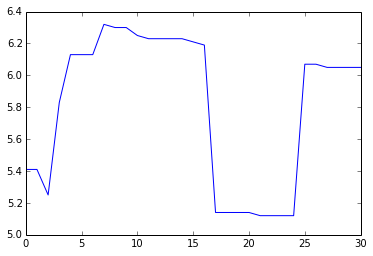

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(stack)

In [15]:
a = np.array([True, False, True])
len(a[a == True])

2